In [2]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import gc
from keras import backend as K

Using TensorFlow backend.
/home/omid/.conda/envs/iot_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Main configs

In [3]:
loadFromMerged=True
loadFromIndexes= True
Mapper='SE'
IgnoreEmpty= False
FoldID ="1"
Epoch_count=60
Batch_size=500

# Load the data the old way


In [4]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [5]:
#  mapps the input records to a integer array for the input
def mapping_x( inp ):
    return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1) for x in inp ])

In [6]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

In [7]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):
    cleans = [] 
    cleans = sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] )
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    
    return ret_x, ret_y

In [8]:
x= []
y= []

x_test = {}
y_test = {}

x_train = {}
y_train = {}



if loadFromMerged:
    with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
        x_data = json.load(f)

    if len( y_data ) != len(x_data) :
        print( pick )
    #     continue

    with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
        index_info = json.load(f)
    
    
    for i in index_info[FoldID]["test"]:
        x_test[str(i)]=( x_data[str(i)] )
        y_test[str(i)]=(  y_data[str(i)] )
    
    for i in index_info[FoldID]["train"]:
        x_train[str(i)]=(  x_data[str(i)] )
        y_train[str(i)]=(  y_data[str(i)] )
    
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
    
    
    x_test,y_test= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
    x_train,y_train= clean_data( x_train, y_train, IgnoreEmpty , Mapping=Mapper )

#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in glob.glob( '../files/train/hub_segments/*.json' ):
        fname  = os.path.basename(pick)
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array( x )
y= np.array(y)

len(x_train), len(y_test)

(50358, 12590)

In [9]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,classes=None ):
#  y data 
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        for x in x_data:
            temp = [] #list(x)
            lst = list(x)
            while dim_size**2 - len(temp )   > len(lst):
                temp.extend(lst)

            while len(temp) < dim_size**2:
                temp.append( 0 )

            x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


        x_data_temp = np.array( x_data_temp )
        x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

# Model Evaluation Methods

In [42]:
def make_recall_shit( inp ):
    tp = inp[0][0]
    tn = inp[1][1]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
    F= 2.0*( prec* recall )/ (prec+recall)
    
    return acc, recall, prec, F
def print_info(y_test, pred , classes, DoPrint=False  ):
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    
    if DoPrint:
        print( "%20s  %8s   %8s  %8s  %8s "  %( "Class","Accuracy",      "Recall","Precision","F Score" ))
        print( "------------------------------------------------------------------------" )
    
        for index in range(len(classes)):
            print( "%20s  %8.3f   %8.3f  %8.3f  %8.3f "  %
                 (classes[index],
                  accs[index][0],
                  accs[index][1],
                  accs[index][2],
                  accs[index][3]
                 )

                 )
    return accs

# Create the Model 

In [11]:
import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2

def unet(dim_size , classcount):
    l2_lambda = 0.0002
    DropP = 0.3
    kernel_size=3

    inputs = Input((dim_size,dim_size,1))
    
    
    conv1 = Conv2D( 32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
    conv1 = bn()(conv1)
    conv1 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)
    conv1 = bn()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(DropP)(pool1)





    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
    conv2 = bn()(conv2)
    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)
    conv2 = bn()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(DropP)(pool2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
    conv3 = bn()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
    conv3 = bn()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(DropP)(pool3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool3)
    conv4 = bn()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
    conv4 = bn()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(DropP)(pool4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
    conv5 = bn()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)
    conv5 = bn()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)
    up6 = Dropout(DropP)(up6)
    conv6 = Conv2D(256,(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
    conv6 = bn()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

    conv6 = bn()(conv6)
    up7 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)
    up7 = Dropout(DropP)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up7)
    conv7 = bn()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)
    conv7 = bn()(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)
    up8 = Dropout(DropP)(up8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up8)
    conv8 = bn()(conv8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)
    conv8 = bn()(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)
    up9 = Dropout(DropP)(up9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
    conv9 = bn()(conv9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
    conv9 = bn()(conv9) 
    
    
    
    flatten1 = Flatten()(conv9)
    conv7 = Dense( 256, activation='relu' )(flatten1)
    conv8 = Dense( 128, activation='relu' )(conv7)
    
    
    output = Dense(classcount,  activation='softmax',name='output')(conv8)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def Do_unet( x_train, y_train , x_test ,y_test, classes ,Batch_size, Epoch_count , return_model=False ):
    dim_size =64
    x_train_processed,y_train_processed, _ = pre_process_raw( x_train, y_train , dim_size, classes=classes)

    model2 = unet(dim_size,len( y_train_processed[0]))
    report2=  model2.fit( x=x_train_processed , y=y_train_processed , batch_size=Batch_size, epochs=Epoch_count , verbose=0)
    
    pred =None
    if x_test is not None:
        x_test_processed,y_test_processed, _ = pre_process_raw( x_test, y_test , dim_size, classes=classes)
        pred= model2.predict( x_test_processed )
    
    if return_model:
        return model2, report2, pred, y_test_processed
    else : 
        K.clear_session()
        del model2
        mx = np.max(report2.history['acc'])
        del report2
        return None, mx, pred, y_test_processed

In [13]:
# model2.save( "UNET_LargeData_F%s_E%d_B%d_M%s_%r" %
#             (
#             FoldID,
#                 Epoch_count,
#                 Batch_size,
#                 Mapper,
#                 IgnoreEmpty
#             ) 
#            )

# Calcualte per class accuracy

In [14]:
# try:
#     print(X_test is None)
#     np.save( "x_test.npy", X_test )
#     np.save("y_test.npy", y_test)
#     np.save("y_pred.npy", pred )
#     np.save("classes.npy", classes)
# except:
#     X_test = np.load("x_test.npy")
#     y_test = np.load("y_test.npy")
#     pred   = np.load("y_pred.npy")
#     classes = np.load("classes.npy")

# Random Forest baseline calc

In [15]:
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [16]:
from sklearn.ensemble import RandomForestClassifier
def Do_RF ( x_train , y_train , x_test , y_test, classes, return_model = False ):
    dim_size= 160
    x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
    
    clf = RandomForestClassifier(n_estimators=260, max_depth=200,
                                 random_state=0 )
    t_hist = clf.fit(x_random_forest_train, y_random_forest_train)

    rf_pred = None 
    if x_test is not None  :
        x_random_forest_test,y_random_forest_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False, classes=classes)
        rf_pred= clf.predict(x_random_forest_test  )

    if return_model : 
        return clf, t_hist, rf_pred, y_random_forest_test
    else : 
        
        del clf
        return None, t_hist, rf_pred, y_random_forest_test


In [17]:
# print_info(y_random_forest_test, rf_pred, classes)

In [18]:
# print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

# LSTM 

In [19]:
# create the model
def Do_lstm( x_train , y_train , x_test, y_test , Epoch_count ,Batch_size, classes, return_model=False):
    dim_size =160
    x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
    word_count = np.max( x_lstm_prossed_train)+1 # len(np.unique( x ))

    # create the model
    embedding_vecor_length = 102
    model = Sequential()
    model.add(Embedding(word_count, embedding_vecor_length, input_length=dim_size))
    model.add(Dropout(0.1))
    model.add(LSTM(100))

    model.add(Dense(127, activation='relu'))
    model.add(Dense(len(classes), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', , metrics=['accuracy'])
#     print(model.summary())
    hist2 = model.fit(x_lstm_prossed_train, y_lstm_prossed_train, epochs=Epoch_count, batch_size=Batch_size, verbose=0)
    
    if x_test is not None :
        x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)
        pred = model.predict( x_lstm_prossed_test )
    
    if return_model:
        return model , hist2, pred , y_lstm_prossed_test
    else :

        mx  = np.max(hist2.history['acc'])
        del hist2
        K.clear_session()
        del model
        return None , mx, pred , y_lstm_prossed_test
    
    
    

In [19]:
CNNs = [] 
lstms = []
rfs = []

_,_ , classes = pre_process_raw( x_train, y_train , 160, zero_pad=True, normalize=False)

for i in range( 200,len ( x_train ) , 200 ):
    CNNs.append( Do_unet(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) )
    lstms.append( Do_lstm(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) )
    rfs.append( Do_RF(x_train[:i], y_train[:i], x_test, y_test, classes) )
    gc.collect()
    print ("*")
    if i % 1000 == 0:
        print( "done %d of %d" %( i , len(x_train) ))

*
*
*
*
*
done 1000 of 50358
*
*
*
*
*
done 2000 of 50358
*
done 3000 of 50358
*
*
*
*
*
done 4000 of 50358
*
*
*
*
*
done 5000 of 50358
*
*
*
*
*
done 6000 of 50358
*
*
*
*
*
done 7000 of 50358
*
*
*
*
*
done 8000 of 50358
*
*
*
done 15000 of 50358
*


KeyboardInterrupt: 

In [25]:
CNNs2 = [] 
lstms2 = []
rfs2 = []

for i in range(len(CNNs)):
    CNNs2.append( [ i*200 , CNNs[i]] )
    lstms2.append( [ i*200 , lstms[i]])
    rfs2.append( [ i*200 , rfs[i]])

CNNs = CNNs2
lstms=lstms2
rfs = rfs2

In [28]:
K.clear_session()

In [ ]:

# for k in range÷( 15200,len ( x_train ) , 2000 ):
k= 1
i =15400
while True:
    i = (k*200)+2000 + i 
    k+=10
    if i >= len(x_train) : 
        break 
    CNNs2.append( [i, Do_unet(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size)] )
    lstms2.append([i, Do_lstm(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) ])
    rfs2.append( [i, Do_RF(x_train[:i], y_train[:i], x_test, y_test, classes) ])
#     gc.collect()
#     print ("*")
#     if i % 1000 == 0:
    print( "done %d of %d" %( i , len(x_train) ))

done 17600 of 50358
done 21800 of 50358
done 28000 of 50358
done 36200 of 50358


In [25]:
len(CNNs2)

81

In [35]:
CNNs2 = np.array( CNNs2 )
lstms2 = np.array(lstms2)
rfs2  = np.array(rfs2)

In [26]:
np.save( "cnns2.npy" , CNNs2 )
np.save( "lstms2.npy", lstms2)
np.save( "rfs2.npy", rfs2)

In [20]:
CNNs2 =list( np.load( "cnns.npy" ))
lstms2 = list(np.load("lstms.npy" ))
rfs2  = list(np.load("rfs.npy"))

In [23]:

_,_ , classes = pre_process_raw( x_train, y_train , 160, zero_pad=True, normalize=False)


In [37]:
classes

['acceleration-active',
 'acceleration-inactive',
 'activity-hubDisconnected',
 'activity-offline',
 'activity-online',
 'battery-XXX',
 'button-held',
 'button-pushed',
 'colorTemperature-XXX',
 'contact-closed',
 'contact-open',
 'level-XXX',
 'lock-locked',
 'lock-unlocked',
 'motion-active',
 'motion-inactive',
 'none',
 'ping-ping',
 'status-closed',
 'status-open',
 'switch-off',
 'switch-on',
 'temperature-XXX',
 'threeAxis-XXX',
 'water-dry',
 'water-wet']

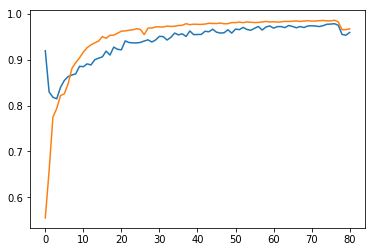

In [28]:
plt.plot( [ pick[1][1] for pick in CNNs2  ] )
plt.plot( [ pick[1][1] for pick in lstms2  ] )

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.colors as pltc
from random import sample


acc_cnns = [ print_info( pick[1][3], fix_pred(  pick[1][2]), classes=classes )  for pick in CNNs2  ]
acc_lstm = [ print_info( pick[1][3], fix_pred(  pick[1][2]) , classes=classes)  for pick in lstms2  ]
acc_rf = [ print_info( pick[1][3], fix_pred(  pick[1][2]) , classes=classes)  for pick in rfs2  ]

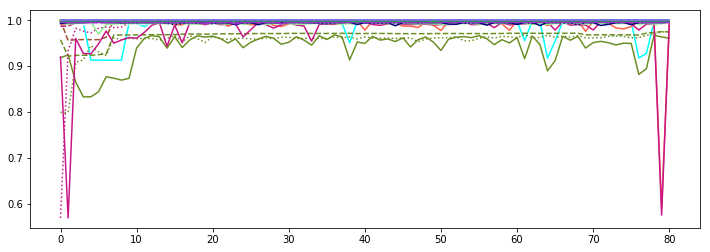

In [69]:
all_colors = [k for k,v in pltc.cnames.items()]
colors = ['coral',
 'sienna',
 'lightcoral',
 'darkgray',
 'lightyellow',
 'tan',
 'sandybrown',
 'cyan',
 'aliceblue',
 'brown',
 'lavender',
 'lavenderblush',
 'palevioletred',
 'tomato',
 'gainsboro',
 'hotpink',
 'olivedrab',
 'mediumvioletred',
 'orangered',
 'forestgreen',
 'lightgreen',
 'navy',
 'darkorchid',
 'seagreen',
 'lime',
 'mediumslateblue']

plt.figure(figsize=(12,4))

for ind in range(len( classes )):
    plt.plot([ p[ind][3] for p in acc_cnns ], c=colors[ind], linestyle='-' , label='cnn_'+ classes[ind])
    plt.plot([ p[ind][3] for p in acc_lstm], c=colors[ind], linestyle=':', label='lstm_'+ classes[ind])
    plt.plot([ p[ind][3] for p in acc_rf], c=colors[ind], linestyle='--',  label ='rf_'+ classes[ind])


# def fix_pred(pred):
#     pred[pred>=0.5] = 1
#     pred[pred<0.5] = 0
#     return pred.astype(int)



# acc_cnns = [ accuracy_score( pick[1][3], fix_pred(  pick[1][2]) )  for pick in CNNs2  ]
# acc_lstm = [ accuracy_score( pick[1][3], fix_pred(  pick[1][2]) )  for pick in lstms2  ]
# acc_rf = [ accuracy_score( pick[1][3], fix_pred(  pick[1][2]) )  for pick in rfs2  ]
# plt.legend()

In [62]:
len(classes)

26

In [90]:
v= [   abs(pick[1][3]- fix_pred(  pick[1][2]))  for pick in rfs2  ]

Text(0, 0.5, 'accuracy')

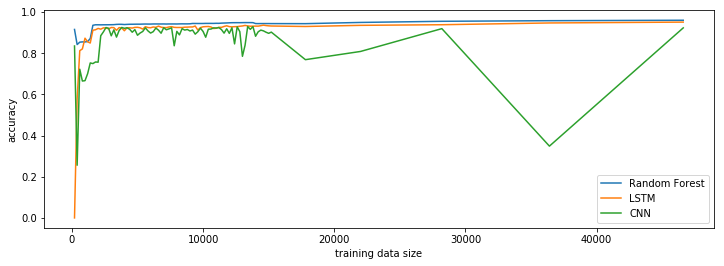

In [107]:
cnn_acc = []
indexes  = [x[0]+200 for x in rfs2  ]    
plt.figure(figsize=(12,4))
lists   = [rfs2,lstms2, CNNs2]
lables = ['Random Forest', 'LSTM', 'CNN']

for i in range(3) :
#     v= [abs(pick[1][3]- fix_pred(  pick[1][2]))  for pick in i  ]
#     xx= np.sum(v[-1],axis=1) 
#     print(len(xx[xx==0])* 1.0/ len(xx))
     
    xx= [np.sum(cc ,axis=1)  for cc in [abs(pick[1][3]- fix_pred(  pick[1][2]))  for pick in lists[i]  ]]
    xx= [ len(p[p==0])* 1.0/ 12590 for p in xx  ]
    plt.plot(indexes,xx, label =lables[i] )
    
plt.legend()
plt.xlabel('training data size')
plt.ylabel('accuracy')


In [98]:
a = np.array([1,2,2,4,4,5,56,6,6,0,0,0]). ( lambda x: x>0 )

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [97]:
len(v[0]), len(xx)

(12590, 12590)

In [ ]:
['coral',
 'sienna',
 'lightcoral',
 'darkgray',
 'lightyellow',
 'tan',
 'sandybrown',
 'cyan',
 'aliceblue',
 'brown',
 'lavender',
 'lavenderblush',
 'palevioletred',
 'tomato',
 'gainsboro',
 'hotpink',
 'olivedrab',
 'mediumvioletred',
 'orangered',
 'forestgreen',
 'lightgreen',
 'navy',
 'darkorchid',
 'seagreen',
 'lime',
 'mediumslateblue']

In [70]:
x_train[0]

array([-271,   99,  403,  405,  -99,  -99,  401,  -99])

In [71]:
y_train[0]

array(['switch-on', 'level-XXX'], dtype='<U9')